Travaux pratiques pour modéliser un système de communication

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.channels import awgn

Constantes

In [2]:
M = 4               # Size of the signal constellation
k = int(np.log2(M)) # Number of bits per symbol
sps = 100           # Samples per symbol
N = 50              # Number of data bits

Transmitter
To do :
1. Allocate data to each level ([1, -1] or [1,0.33,-0.33,-1])
2. Upsample with zeros
2. Generate pulse (RRC) and plot
3. Apply pulse shapping (convolve)
4. Plot

In [3]:
data = np.random.randint(M, size=int(N/k))
txSig = data
print(txSig)

[3 3 0 1 1 1 3 1 3 0 3 2 0 0 0 1 2 0 3 0 1 0 2 3 3]


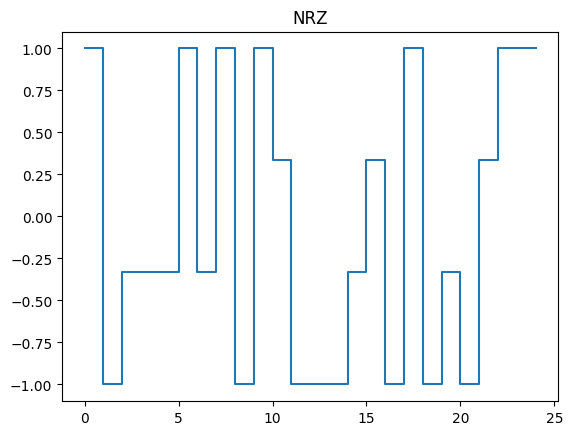

In [4]:
def convertToNRZ (dataToConvert) :
    distance = 2 / (M - 1)
    minVAL = -1
    nrz = []
    for elem in dataToConvert :
        nrz.append(minVAL + elem * distance)
    return nrz

txNrz = convertToNRZ(txSig)
plt.step(np.arange(0, len(txNrz)), txNrz)
plt.title('NRZ')
plt.show()

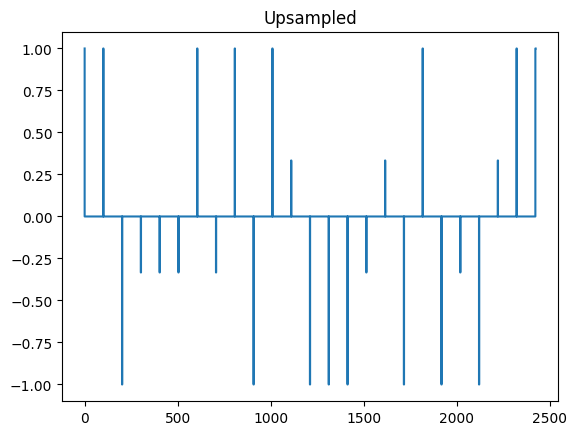

In [17]:
txUpsampled = np.zeros(len(txNrz) + (len(txNrz) - 1) * sps)
txUpsampled[::sps + 1] = txNrz
plt.step(np.arange(0, len(txUpsampled)), txUpsampled)
plt.title('Upsampled')
plt.show()


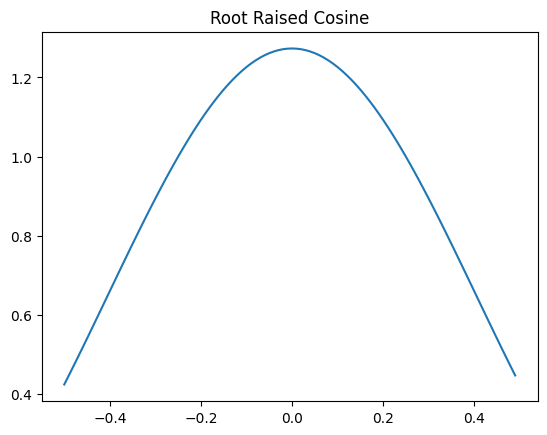

In [18]:
from commpy.filters import rrcosfilter
rolloff = 1.0
ts = 1.0
t, pulse = rrcosfilter(sps, rolloff, ts, sps)
plt.plot(t, pulse)
plt.title('Root Raised Cosine')
plt.show()

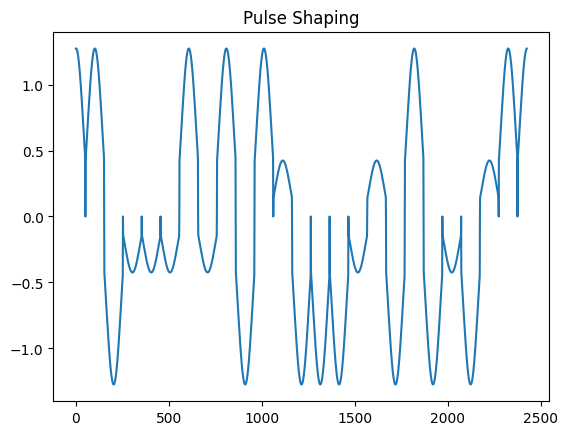

In [7]:
# Apply pulse shaping convolve
txSigShaped = np.convolve(txUpsampled, pulse, mode='same')
plt.plot(txSigShaped)
plt.title('Pulse Shaping')
plt.show()

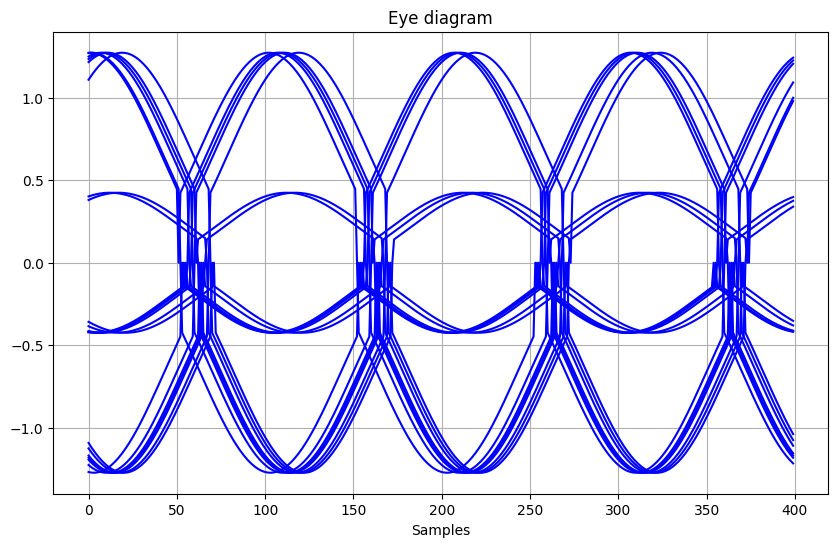

In [8]:
def plotEyeDiagram(signal, num_symbols=M):
    plt.figure(figsize=(10, 6))
    num_samples = num_symbols * sps
    for i in range(0, len(signal) - num_samples,sps):
        plt.plot(np.real(signal[i:i+num_samples]), 'b')
    plt.title("Eye diagram")
    plt.xlabel("Samples")
    plt.grid(True)
    plt.show()

plotEyeDiagram(txSigShaped)

Channel

In [9]:
EbNo = 10;   #en dB
snr = EbNo + 10*np.log10(k) - 10*np.log10(0.5*sps); #snr: S/N per sample in dB
rxSig = awgn(txSigShaped, snr)

Receiver
To do:
1. Apply RRC again
2. Take a sample every Tb
3. Decide if it is [1, -1] (M=2) or [1,0.33,-0.33,1] (M=4)

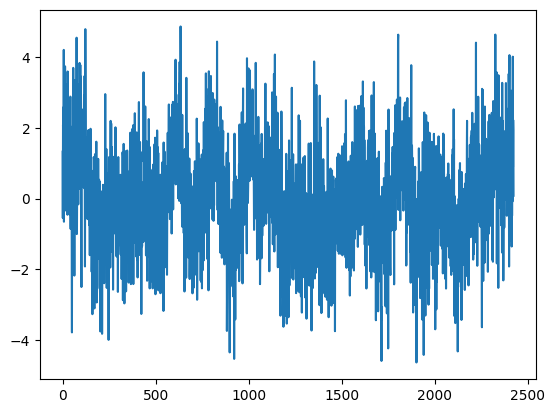

In [10]:
plt.plot(rxSig)

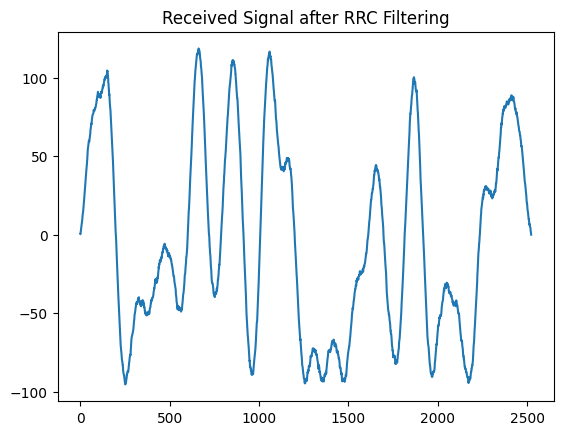

In [11]:
rxFiltered = np.convolve(rxSig, pulse)

plt.plot(rxFiltered)
plt.title('Received Signal after RRC Filtering')
plt.show()

In [12]:
def sampler(signal):
    return signal[::sps + 1]

def defineLevel(signalToDefine):
    bits=[]
    if M == 4:
        for i in range(len(signalToDefine)):
            if signalToDefine[i] >= 0.5 * sps:
                bits.append(3)
            elif signalToDefine[i] >= 0:
                bits.append(2)
            elif signalToDefine[i] <= (-0.5) * sps:
                bits.append(0)
            else:
                bits.append(1)
    else:
        for i in range(len(signalToDefine)):
            if signalToDefine[i] >= 0:
                bits.append(1)
            else:
                bits.append(0)
    return bits

rxSampled = sampler(rxFiltered)
rxSigTransformed = np.array(defineLevel(rxSampled))

print(rxSigTransformed)
print(data)


[2 3 1 0 1 1 2 2 2 2 2 3 1 0 0 0 2 1 2 2 0 0 1 2 3]
[3 3 0 1 1 1 3 1 3 0 3 2 0 0 0 1 2 0 3 0 1 0 2 3 3]


BER
To do:
1. Compare input with output, compute BER
2. Add a loop to vary Eb/N0 from 0 to 10dB by step of 0.1 dB
3. Plot BER vs. Eb/N0 curve

In [13]:
def countError(tx, rx):
    errors = np.sum(tx != rx)

    return errors/len(tx)

print( "BER = " + str(countError(txSig, rxSigTransformed)))

BER = 0.68


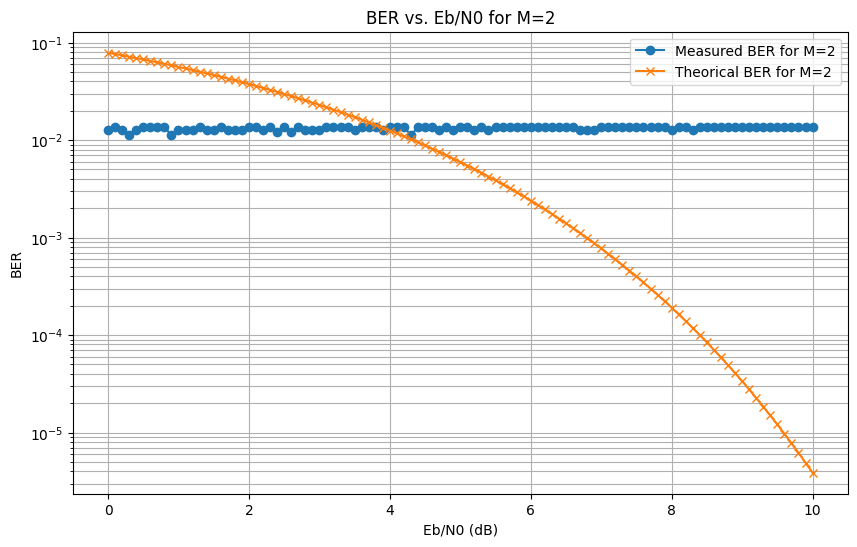

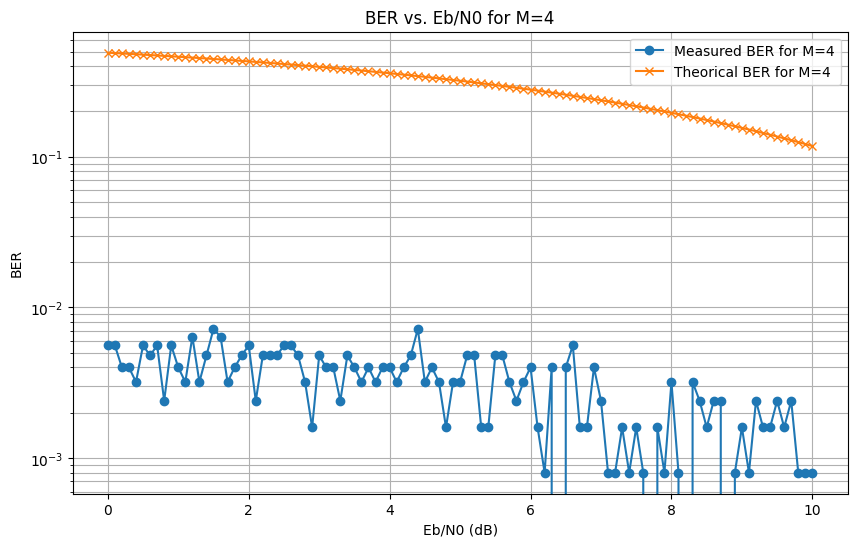

In [15]:
from scipy.special import erfc

ber_M2 = []
ber_M4 = []
ber_theoretical_M2 = []
ber_theoretical_M4 = []

EbNo_range = np.arange(0, 10.1, 0.1)
for EbNo in EbNo_range:
    snr = EbNo + 10 * np.log10(k) - 10 * np.log10(0.5 * sps)
    
    M = 2
    rxSig_M2 = awgn(txSigShaped, snr)
    rxFiltered_M2 = np.convolve(rxSig_M2, pulse, mode='same')
    rxSampled_M2 = sampler(rxFiltered_M2)
    rxSigTransformed_M2 = np.array(defineLevel(rxSampled_M2))
    ber_M2.append(countError(txSig, rxSigTransformed_M2) / N)
    
    M = 4
    rxSig_M4 = awgn(txSigShaped, snr)
    rxFiltered_M4 = np.convolve(rxSig_M4, pulse, mode='same')
    rxSampled_M4 = sampler(rxFiltered_M4)
    rxSigTransformed_M4 = np.array(defineLevel(rxSampled_M4))
    ber_M4.append(countError(txSig, rxSigTransformed_M4) / N)
    
    ber_theoretical_M2.append(0.5 * erfc(np.sqrt(10**(EbNo/10))))
    ber_theoretical_M4.append(0.75 * erfc(np.sqrt(0.1 * 10**(EbNo/10))))

# For M=2
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_range, ber_M2, 'o-', label='Measured BER for M=2')
plt.semilogy(EbNo_range, ber_theoretical_M2, 'x-', label='Theorical BER for M=2')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.title('BER vs. Eb/N0 for M=2')
plt.legend()
plt.grid(True, which='both')
plt.show()

# For M=4
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_range, ber_M4, 'o-', label='Measured BER for M=4')
plt.semilogy(EbNo_range, ber_theoretical_M4, 'x-', label='Theorical BER for M=4')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.title('BER vs. Eb/N0 for M=4')
plt.legend()
plt.grid(True, which='both')
plt.show()

